# Decoding analysis using the spiking activity of multiple cells

Maximum likelihood decoding from the spiking activity of multiple cells together. For this analysis we use the already binned spiking as in the GLM analysis. The stored data already as the modified activity where the modulation due to speed and acceleration was subtracted based on GLM regression.

In the end, we obtain the decoding accuracy as function of the increasing number of cells that are included for decoding. The cells are sorted according to the single-cell decoding performance and mean firing rate as obtained in the full single-cell decoding analysis.

# Imports and module reloading

In [1]:
#%matplotlib inline

import os
import sys
import glob
import re
from pathlib import Path
import json
import importlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# My module for the decoding analysis
#import decoding
from decoding import *

# Load data from the regression analysis

In [2]:
base_p = Path(os.getcwd())
start_p = base_p / 'data'
print(start_p)

/Users/sven/Work/Projects/DecodingAnalysisMei/data


In [3]:
# Select decoding start offset relative to reward delievery time:
# decoding windows are considered before and after this start
decoding_offset_time = 1.5 # in s
# decoding_offset = round(decoding_offset_time * sample_rate_Hz)

# Session status
# Load data from expert or non-expert animals
# Change this from expert_s to non_expert_s to load the corresponding data
session_s = expert_s # non_expert_s
session_status = session_s

cells_data_fname = 'activity_subtracted_data__' + session_s + '.npy'
fname = start_p / cells_data_fname

cells_data_d = np.load(fname, allow_pickle=True).item()

print('Number of cells:', len(cells_data_d))
list(cells_data_d.keys())

Number of cells: 50


['Expert__#386_2020-07-21__shank1_5.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank2_43.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank2_24.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank2_34.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank2_70.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank2_42.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank2_47.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank3_17.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank3_33.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank4_106.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank4_96.0_fam_SOMI',
 'Expert__#386_2020-07-21__shank4_95.0_fam_SOMI',
 'Expert__#384_2020-07-23__shank3_81.0_fam_SOMI',
 'Expert__#384_2020-07-23__shank4_40.0_fam_SOMI',
 'Expert__#384_2020-07-23__shank4_42.0_fam_SOMI',
 'Expert__#387_2020-07-24__shank1_16.0_fam_SOMI',
 'Expert__#387_2020-07-24__shank2_24.0_fam_SOMI',
 'Expert__#387_2020-07-24__shank2_44.0_fam_SOMI',
 'Expert__#387_2020-07-24__shank3_35.0_fam_SOMI',
 'Expert__#328_2020-04-02__shank1_25.0_fam_SOMI',


## Load sorted keys of the cells for simultaneous decoding.
We valuate a decoder that uses the spike counts of multiple units simultaneously (naive Bayesian classifier). We do this for a selected subset of units, which is determined according to some criteria. For example, we could start with one cells and then increase the number according to some criteria. For this, we sort the list of cells, using the dict keys.

In [4]:
def replace_underscore(key_s):
    ind = key_s.find('shank')+6
    return key_s[:ind] + '_' + key_s[ind+1:]

In [5]:
# # Select decoding start offset relative to reward delievery time:
# # decoding windows are considered before and after this start
# decoding_offset_time = 1.5 # in s
# decoding_offset = round(decoding_offset_time * sample_rate_Hz)
bw_ms = 200

# Split variant for two-fold cross-validation:
split_variant = 0 # Split into even and odd trials
split_variant_name = split_variant_names[split_variant]
#print('Using split variant:', split_variant_name)
decoding_s = f'_bw{bw_ms}' + f'_split_{split_variant_name}'
#print(decoding_s)

# Load the list of sorted keys
pv_level = 0.01

# Use sorting from the original analysis:
keys_sorted_name_s = session_status + '__keys_sorted' + f'_offset{decoding_offset_time:.1f}' + decoding_s + f'_pv{100*pv_level:02.0f}'
fname = start_p / (keys_sorted_name_s  + '.txt')

#Now read the file back into a Python list object
with open(fname, 'r') as f:
    keys_sorted_orig = json.loads(f.read())

#Saved with json.dumps
# with open(fname, 'w') as f:
#     f.write(json.dumps(keys_sorted[::-1]))

In [6]:
keys_sorted = [replace_underscore(key) for key in keys_sorted_orig]

# "Cell with high firing rate and thus decoding accuracy"
super_cell_id = 'Expert__#233_lin_2019-12-18__shank2_47.0_fam_SOMI'
# TODO: change '-' after shank? i cell_id string
# in keys from original full analysis

len(keys_sorted)

44

# Training of the decoder and compute log-probabilities

For training, we compute for each unit separately the expected counts from the aligned rate counts for before and after the decoding start time.

In [7]:
def train_all(bin_window, bin_width, num_bins, cells_data_d, repeat=0, split=0):
    # Range of indices for the binned data for the given bin_window
    idx_range_before, idx_range_after = get_window_idx(bin_window, bin_width, num_bins)
    idx_window = list(idx_range_before) + list(idx_range_after)
    # rate_counts_train = rate_counts_aligned[:, list(idx_range_before) + list(idx_range_after)]
    
    for cell_id_s, data_d in cells_data_d.items():
        #print(cell_id_s)

        num_trials = data_d['num_reward_start']
        if split == None:
            train_inds = np.arange(num_trials) #range(num_trials)
            test_inds = np.arange(num_trials) #range(num_trials)
        else:
            inds_split = split_even_odd(num_trials)
            # select train and test trials:
            train_inds = inds_split[split] 
            test_inds = inds_split[(split+1) % 2]

        # Restrict the data arrays for the decoding analysis to the shorter bin_window:
        spike_counts_aligned = data_d['spike_counts_list'][repeat][:, idx_window]
        rate_counts_train = spike_counts_aligned[train_inds, :]
        labels_train = data_d['true_labels'][train_inds]
        
        # Corresponding restricted data arrays to be used for testing
        spike_counts_test = spike_counts_aligned[test_inds, :]
        labels_temp = np.reshape(data_d['true_labels'][test_inds], (-1,), order='C')
                
        train_inds = np.arange(rate_counts_train.shape[0]) #range(num_trials) # inds_split[0]
        # Training
        expect_before, expect_after = train_decoder(rate_counts_train, labels_train, train_inds)
        
        # At this point, we can already compute the log-probs
        # for each spike count pattern
        #test_inds = np.arange(spike_counts_test.shape[0]) #range(num_trials) # inds_split[1]
        spike_counts_temp = np.reshape(spike_counts_test,
                                       (-1, spike_counts_test.shape[1]//2), order='C')
        decoded_labels, log_probs = get_decoded_labels(spike_counts_temp,
                                                       expect_before.mean(), expect_after)
        
        # log-probabilities of before and after
        # see: log_probs = np.array([log_prob_before, log_prob_after]) 
        
        # store log-probs and corresponding true labels for testing: labels_temp
        data_d['repeat'] = repeat
        data_d['split'] = split
        data_d['window'] = bin_window # the selected window length
        data_d['labels_decode'] = labels_temp
        data_d['log_probs'] = log_probs
        
        # compute accuracy
        frac_correct, num_correct = get_accuracy(decoded_labels, labels_temp)
        #print('Accuracy:', frac_correct)
        data_d['frac_correct'] = frac_correct
    return


def test_decoding_all(keys_sorted, cells_data_d, num_test_decoding = 10_000):
# Put computed log-probs and labels for testing of decoding in lists:
    labels_decode_l = []
    log_probs_l = []
    num_test_trials_l = []
    for key in keys_sorted:
        #print(key)
        labels_decode_l.append(cells_data_d[key]['labels_decode'])
        log_probs_l.append(cells_data_d[key]['log_probs'])
        num_test_trials_l.append(cells_data_d[key]['labels_decode'].shape[0]//2)
    
    # Actual testing:
    labels_trial = np.array([0,1])
    num_correct = np.zeros((len(keys_sorted),2), dtype=int)
    for r in range(num_test_decoding):
        log_probs_cells = np.zeros((len(keys_sorted),2,2))
    
        for i, key in enumerate(keys_sorted):
            num_test_trials = labels_decode_l[i].shape[0]//2
            trial_ind = rng.choice(num_test_trials)
            #labels_trial = labels_decode_l[i][2*trial_ind:2*(trial_ind+1)] # equals array([0,1])
            log_probs_temp = log_probs_l[i][2*trial_ind:2*(trial_ind+1),:]
            log_probs_cells[i] = log_probs_temp
            
        log_probs_csum = np.cumsum(log_probs_cells, axis=0)
        decoded_labels = np.argmax(log_probs_csum, axis=2)
        num_correct += (decoded_labels == labels_trial)

    frac_correct = num_correct/num_test_decoding
    return frac_correct

# Testing of the decoder

For the selected subset of units we choose spike count patterns all from the same class (0 for "before" and 1 for "after") but otherwise at random from the trials in the session. The true class is stored in `data_d['labels_decode']` and accordingly the individual log-probabilities in `data_d['log_probs_decode']`, both have the length of the twice the number of trials.

In the end, we simply add the corresponding log-probs for the different units, both for "before" and "after".

## Repeat the testing of the decoder a number of times

Obtain the number/fraction of correct decodings for increasing number of cells used for decoding.
We want to investigate a several window lengths in the following.

In [8]:
# Remove keys that are not in the binned data:
for key in keys_sorted:
    if not (key in cells_data_d.keys()):
        print(key + ' is not in binned data and removed from analysis.')
        keys_sorted.remove(key)

len(keys_sorted)

Expert__#384_2020-07-23__shank3_90.0_fam_SOMI is not in binned data and removed from analysis.


43

In [9]:
# Random number generator for testing
rng = np.random.default_rng()
rng_state = rng.bit_generator.state

In [10]:
# Remove high firing cell from above:
remove_super = True # False

if remove_super and super_cell_id in keys_sorted:
    keys_sorted.remove(super_cell_id)

len(keys_sorted)

42

In [11]:
# We do the following for a fixed window length, for now:
data_d = next(iter(cells_data_d.values())) # get first value in dictionary
#print(data_d['cell_id_s'])
bin_width = data_d['bin_width'] # should be the same for all units
num_bins = data_d['num_bins']

# Window lengths for analysis:
win_start = 0.5 # in seconds
win_stop = 1.5 # should be less than (or equal to) window_max
win_step = bin_width #max(0.125, bin_width) #0.125 in seconds, 2**-3
windows = create_windows(win_start, win_stop, win_step)

num_repeat = data_d['num_repeat']
fcs_arr_rep_l = []

split_l = [0, 1] #[None]

#rng_state_l = []

for rep in range(num_repeat+1):
    print('Repeat:', rep)
    fcs_arr_split_l = []
    for split in split_l:
        print('Split:', split)
        fcs_l = []
        rng_state = rng.bit_generator.state
        #rng_state_l.append(rng_state)
        for window in windows:
            train_all(window, bin_width, num_bins, cells_data_d, repeat=rep, split=split)
            rng.bit_generator.state = rng_state # reset the state of rng used for the decoding
            frac_correct = test_decoding_all(keys_sorted, cells_data_d, num_test_decoding = 10_000)
            # uses the data from training with the chosen window before
            fcs_l.append(frac_correct)
        
        fcs_arr = np.array(fcs_l).mean(axis=2)
        fcs_arr_split_l.append(fcs_arr)
        # if split == 1:
        #     fcs_arr += np.array(fcs_l).mean(axis=2)
        #     fcs_arr *= 0.5
        #     split = 2
        # else:
        #     fcs_arr = np.array(fcs_l).mean(axis=2)

    #print(fcs_arr.shape)
    fcs_arr_rep_l.append(np.array(fcs_arr_split_l))

# Put all fraction correct data in array: 
fcs_arr_rep = np.array(fcs_arr_rep_l)
fcs_arr_rep.shape

Repeat: 0
Split: 0
Split: 1
Repeat: 1
Split: 0
Split: 1


(2, 2, 5, 42)

In [12]:
# Save results of population decoding analysis:
if remove_super:
    with_super_s = ''
else:
    with_super_s = '_with_super'

data_name_s = (session_s + '__pop_dec_plot_data' + f'_offset{decoding_offset_time:.1f}'
               + f'_pv{100*pv_level:02.0f}' + '_cv' + str(len(split_l)).lower() + with_super_s)

fname = start_p / data_name_s
np.savez(fname, windows=windows, fcs_arr_rep=fcs_arr_rep)

# Load and plot saved data

In [13]:
# Load saved data
# session_s = expert_s
# split = 0
cv_s = '2'

if remove_super:
    with_super_s = ''
else:
    with_super_s = '_with_super'
#with_super_s = ''
#with_super_s = '_with_super'

data_name_s = (session_s + '__pop_dec_plot_data' + f'_offset{decoding_offset_time:.1f}'
               + f'_pv{100*pv_level:02.0f}' + '_cv' + cv_s + with_super_s)

fname = start_p / (data_name_s + '.npz')
data = np.load(fname)
windows = data['windows']
fcs_arr_rep = data['fcs_arr_rep'] # Layout: reps x splits x windows x neurons incl
# fcs_arr = data['fcs_arr']
data.close()

if len(with_super_s) > 0:
    fcs_arr_rep_super = fcs_arr_rep.copy()

# fcs_arr = fcs_arr_rep[0]

In [14]:
#mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
# this makes sure the text objects are recognized as texts in the final vector plot, not vector shapes

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']

SMALL_SIZE = 8
MEDIUM_SIZE = 9
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#cmap = mpl.colormaps['plasma']
#cmap = mpl.colormaps['cool']

In [21]:
# Choose between original spiking activity data and
# activity where the modulation due to speed and acc.
# has been subtracted using the GLM regression.

# Switch this:
repeat = 0 # 0: original data
# 1: activity with subtracted speed and acc. modulation

fcs_arr_split = fcs_arr_rep[repeat]

# Average over the two folds in the cross-validation scheme:
fcs_arr = fcs_arr_split.mean(axis=0)
#print(fcs_arr.shape)
num_cells = np.arange(1, fcs_arr.shape[1]+1)

if len(with_super_s) > 0:
    fcs_arr_super = fcs_arr_rep_super[repeat].mean(axis=0)
    num_cells_super = np.arange(1, fcs_arr_super.shape[1]+1)
    #fcs_arr_super.shape

Plot window lengths: [0.75 1.   1.25 1.5 ]


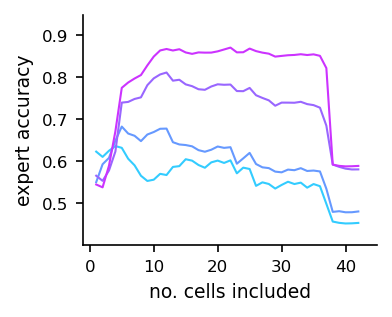

In [22]:
windows_plot = [0.75, 1.0, 1.25, 1.5]
inds_plot = np.searchsorted(windows, windows_plot)
print('Plot window lengths:', windows[inds_plot])

#cmap = mpl.colormaps['Dark2'] #['tab20c']
cmap = mpl.colormaps['cool']

# norm = plt.Normalize(vmin=windows.min(), vmax=windows.max())
norm = plt.Normalize(0.5, 1.75)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
#sm.set_array([])

fig_width = 2.5 
fig_height = 2.0

fig, ax = plt.subplots(1,1, figsize=(fig_width,fig_height), dpi=150, layout="constrained")
#ax.set_prop_cycle('color', colors)

#ax.xaxis.set_inverted(True)
li_l = []
for i in inds_plot:
#for i, fc in enumerate(fcs_arr):
    fc = fcs_arr[i]
    #fc = fcs_arr_rep[:,i]
    li_l += ax.plot(num_cells, fc, color=cmap(norm(windows[i])), lw=1, alpha=1.0,
             label=windows[i])
    # if windows[i] == 1.5:
    #     fc = fcs_arr_super[i]
    #     li_l += ax.plot(num_cells_super, fc, color=cmap(norm(windows[i])), lw=1, ls='--', dashes=(2, 1.5), alpha=1.0,
    #          label=windows[i])

if session_status == non_expert_s:
    pass
    leg = ax.legend(handles=li_l, loc='upper right', frameon=False, handlelength=1.5, handleheight=0.6,
              borderaxespad=0.0,
              fontsize= SMALL_SIZE, reverse=True, title='window (s)', alignment='right')
    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(1.5)
else:
    pass


ax.axes.spines[['top','right']].set_visible(False)
ax.set_yticks(np.linspace(0.5,1.0,6))
ax.set_xticks(np.arange(0,50,10))
ax.set_ylim([0.40, 0.95])
ax.set_xlim([-1, 45])
ax.set_ylabel(session_status.lower() + ' accuracy')
ax.set_xlabel('no. cells included')
#ax.set_title(session_status)

plt.show(fig)

In [23]:
# Save figure:
plots_p = start_p
# with_super_s = '_with_super'

plot_name_s = (session_s + '__pop_dec' + f'_offset{decoding_offset_time:.1f}'
               + f'_pv{100*pv_level:02.0f}' + '_cv' + cv_s + f'_rep{repeat}' + with_super_s)

fname = plots_p / (plot_name_s  + '.pdf')
#print(fname)
fig.savefig(fname, dpi=300, format='pdf', transparent=True) #, facecolor='w')
#pad_inches='layout'
# fname = plots_p / (plot_name_s  + '.eps')
# fig.savefig(fname, dpi=300, format='eps', transparent=True) #, facecolor='w')
fname = plots_p / (plot_name_s  + '.svg')
fig.savefig(fname, dpi=300, format='svg', transparent=True) #, facecolor='w')
plt.close(fig)